In [177]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [178]:
import numpy as np
import pandas as pd

In [179]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [180]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [181]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [182]:
# Create engine.#Use SQLAlchemy create_engine to connect to your sqlite database. 
hawaii_path = "Resources/hawaii.sqlite"

engine_hawaii = create_engine(f"sqlite:///{hawaii_path}")
#engine_hawaii = create_engine(f"sqlite:///Resources/hawaii.sqlite")

hawaii = pd.read_sql("SELECT * FROM measurement", engine_hawaii)
hawaii.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [183]:
hawaii = pd.read_sql("SELECT * FROM station", engine_hawaii)
hawaii.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [184]:
#inspector = inspect(engine_hawaii)
#inspector.get_table_names()

In [186]:
# Reflect an existing database into a new model, ORM class
Base = automap_base()
Base.prepare(engine_hawaii, reflect=True)

# used SQLAlchemy automap_base() to reflect my database into a new model - classes

In [187]:
# We can view all of the classes that automap found

In [188]:
Base.classes.keys()

['measurement', 'station']

In [189]:
# Save references to each table (those classes called Station and Measurement) 

In [190]:
measurement = Base.classes.measurement

In [191]:
station = Base.classes.station

In [192]:
# Create our session (link) from Python to the DB

In [193]:
# The ORM’s “handle” to the database is the Session.
from sqlalchemy.orm import Session
session = Session(engine_hawaii)

In [194]:
inspector = inspect(engine_hawaii)
inspector.get_table_names()

['measurement', 'station']

In [195]:
# Get a list of column names and types fo "measurement" class (table)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
#columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [196]:
# Get a list of column names and types fo "station" class (table)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [197]:
# Designed a query to retrieve the last 12 months of precipitation data and plottted the results
# Calculated the date 1 year ago from the last data point in the database

prcp_results = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date > '2016-08-23').\
    order_by(measurement.date).all()

In [198]:
# Saveed the query results as a Pandas DataFrame and set the index to the date column
# Sorted the dataframe by date sort_valuesprcp_results = prcp_results

prcp_df = pd.DataFrame(prcp_results)
prcp_df.set_index(["date"],inplace=True, drop=True)
prcp_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


Text(0, 0.5, 'Precipitation')

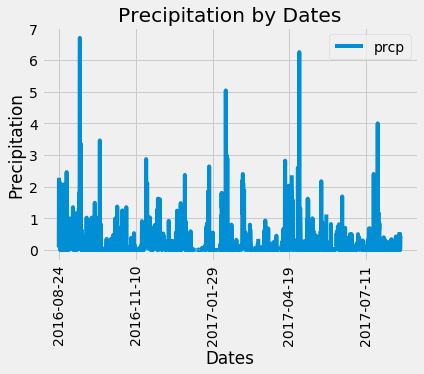

In [199]:
# Used Pandas Plotting with Matplotlib to plot the data and create bar chart

prcp_df.plot(rot=90)
plt.title("Precipitation by Dates")
plt.xlabel('Dates')
plt.ylabel('Precipitation')

In [200]:
# Used Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [201]:
# Designed a query to show how many stations are available in this dataset?
#count
len(session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).all())

9

In [202]:
# What are the most active stations? (i.e. what stations have the most rows)?
# Listed the stations and the counts in descending (max) order.

session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [203]:
# Queried for the date and precipitation (max, mean, min) for all dates in that last year & sorted by date.

session.query(func.max(measurement.tobs),
              func.avg(measurement.tobs),
              func.min(measurement.tobs)).filter(measurement.station == "USC00519281").all()

[(85.0, 71.66378066378067, 54.0)]

In [204]:
# Used station id from the previous query, calculated the lowest, highest, & average temperature recorded, 
# of the most active station for the last 12 months of temperature observation data for this station and plotted
# the results as a histogram


prcp_results = session.query(measurement.tobs).\
    filter(measurement.date > '2016-08-23').\
    filter(measurement.station == "USC00519281").\
    order_by(measurement.date).all()
prcp_df = pd.DataFrame(prcp_results)
prcp_df.head()

,tobs
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0


Text(0, 0.5, '# Observations')

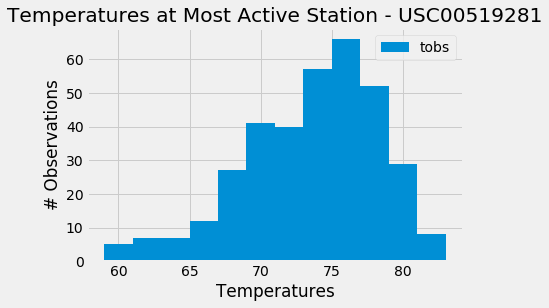

In [205]:
prcp_df.plot.hist(bins=12)
plt.title("Temperatures at Most Active Station - USC00519281")
plt.xlabel('Temperatures')
plt.ylabel('# Observations')

# Part 2 - Climate App

In [206]:
from flask import Flask, jsonify
import datetime as dt

In [207]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [208]:
# Create engine.#Use SQLAlchemy create_engine to connect to your sqlite database. 
hawaii_path = "Resources/hawaii.sqlite"

engine_hawaii = create_engine(f"sqlite:///{hawaii_path}")
#engine_hawaii = create_engine(f"sqlite:///Resources/hawaii.sqlite")

hawaii = pd.read_sql("SELECT * FROM measurement", engine_hawaii)
hawaii.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [209]:
hawaii = pd.read_sql("SELECT * FROM station", engine_hawaii)
hawaii.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [210]:
inspector = inspect(engine_hawaii)
inspector.get_table_names()

['measurement', 'station']

In [211]:
Base = automap_base()
Base.prepare(engine_hawaii, reflect=True)

Base.classes.keys()

['measurement', 'station']

In [212]:
# Saved references to each table (those classes called Station and Measurement) 

measurement = Base.classes.measurement

station = Base.classes.station

In [213]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
#columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [214]:
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [215]:
# Flask Setup

app = Flask(__name__)

In [217]:
# Flask Routes

@app.route("/")
def welcome():
    
    """List all available API routes."""
    
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/about<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/temp_start<br/>"
        f"/api/v1.0/temp-start_end<br/>"
        f"/api/v1.0/contact"
    )

In [218]:
@app.route("/api/v1.0/about")
def about():
   name = "Flynn LLC"
   location = "Arizona"
   
   return f"We are {name} and we are located in sunny {location}."

In [220]:
@app.route("/api/v1.0/precipitation")
def precipitation():
    # Create our session (link) from Python to the DB
    session = Session(engine)

    """Return a list of all precipitation"""
    # Query all measurements
    results = session.query(measure.date,measurement.prcp).all()

    session.close()

    # Convert list of tuples into normal list
    all_precipitation = list(np.ravel(results))

    return jsonify(all_precipitation)

In [221]:
@app.route("/api/v1.0/stations")
def stations():
    # Create our session (link) from Python to the DB
    session = Session(engine)

    """Return a list of all stations"""
    # Query all stations
    results = session.query(station.station).all()

    session.close()

    # Convert list of tuples into normal list
    all_stations = list(np.ravel(results))

    return jsonify(all_stations)

In [222]:
@app.route("/api/v1.0/tobs")
def tobs():
    # Create our session (link) from Python to the DB
    session = Session(engine)

    """Return a list of all tobs"""
    # Query all observations
    results = session.query(hawaii.measurement, tobs).filter(station == id).all()

    session.close()

    # Convert list of tuples into normal list
    all_tobs = list(np.ravel(results))

    return jsonify(all_tobs)

In [223]:
@app.route("/api/v1.0/tobs/<start>")
def tobs_start(start=None):
   
    #Return a list of all tobs # Query all observations
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    results = session.query(*sel).filter(measurement.date).all()

    # Convert list of tuples into normal list
    all_tobs = list(np.ravel(results))

    return jsonify(all_tobs)

In [224]:
@app.route("/api/v1.0/tobs/<start>/<end>")
def tobs_start_end(start=None, end=None):
    # Create our session (link) from Python to the DB
    session = Session(engine)

    """Return a list of all tobs"""
    # Query all observations
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    results = session.query(*sel).filter(measurement.date>=start).filter(mesurement.date<=end).all()

    session.close()

    # Convert list of tuples into normal list
    all_tobs = list(np.ravel(results))

    return jsonify(all_tobs)

In [225]:
@app.route("/api/v1.0/contact")
def contact():
   email = "Flynnworking@gmail.com"
     
   return f"Questions, Comments, Complaints? Send an email to {email}."

In [226]:
if __name__ == "__main__":

 app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with windowsapi reloader


SystemExit: 1

C:\Users\Denise\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
